In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

#from math import comb
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

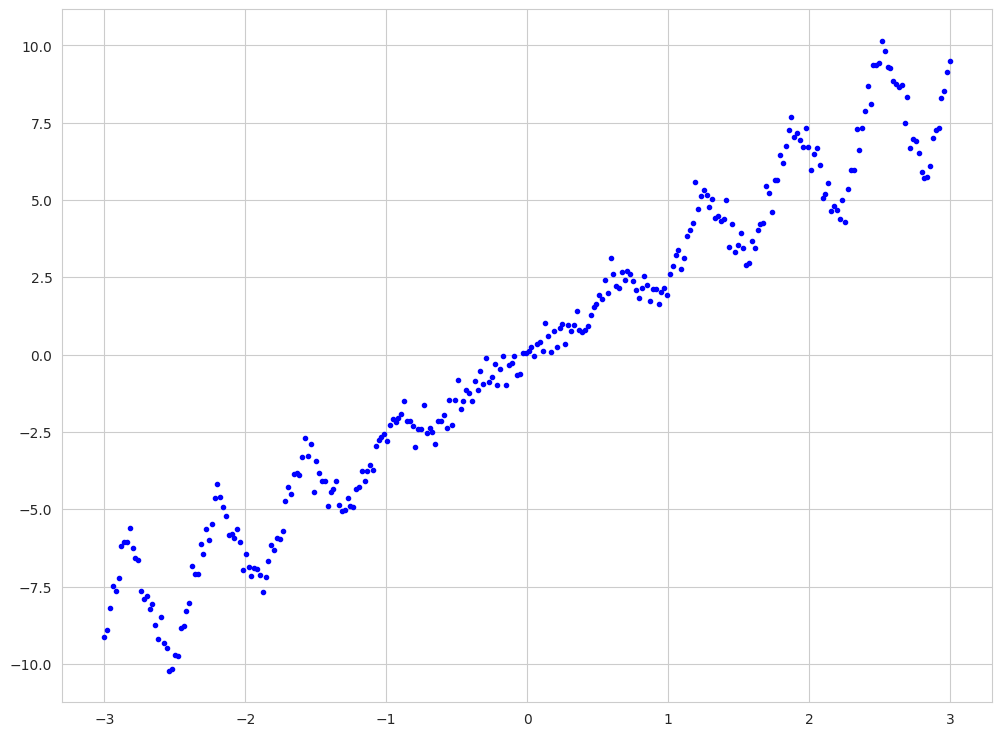

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

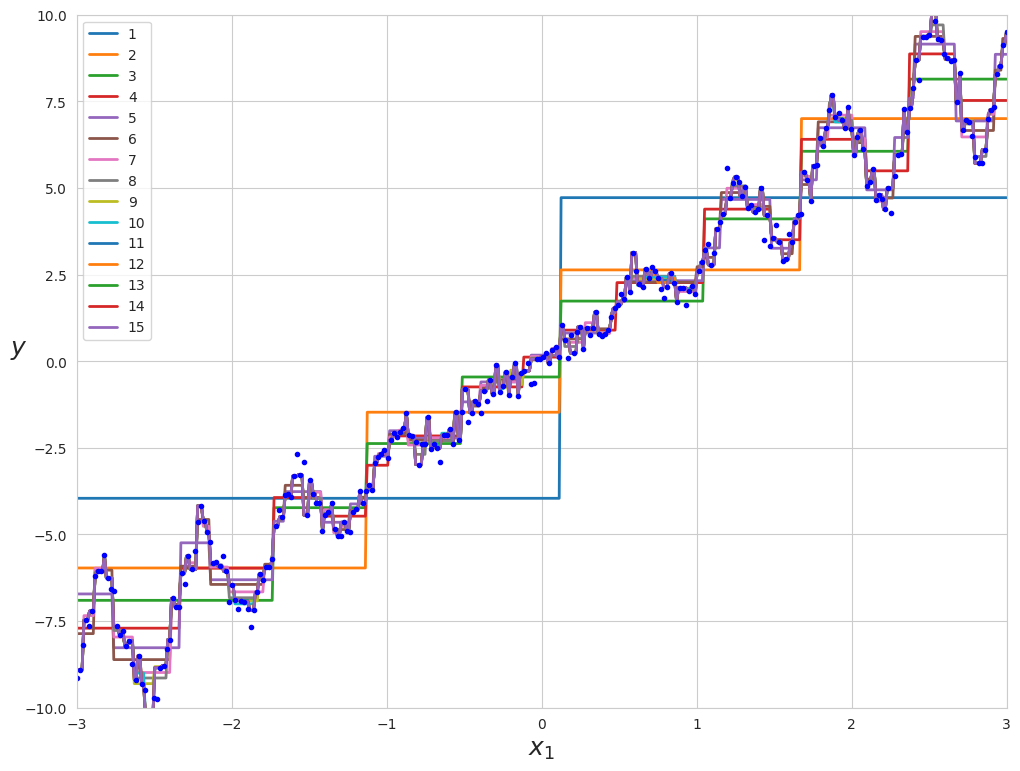

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
depth = []
for i in range (1, 16):
    clf = DecisionTreeRegressor(max_depth=i, random_state=SEED)
    clf.fit(X_train, y_train)
    plot_regression_predictions(clf.fit(X_train, y_train), X_test, y_test, axes=[-3, 3, -10, 10], ylabel="$y$")
    depth.append(i)
    
plt.legend(depth)
plt.plot(X.reshape(-1), y.reshape(-1), "b.")    

Видим, что после n = 7, все остальные линии  почти совпадают, построим отдельно

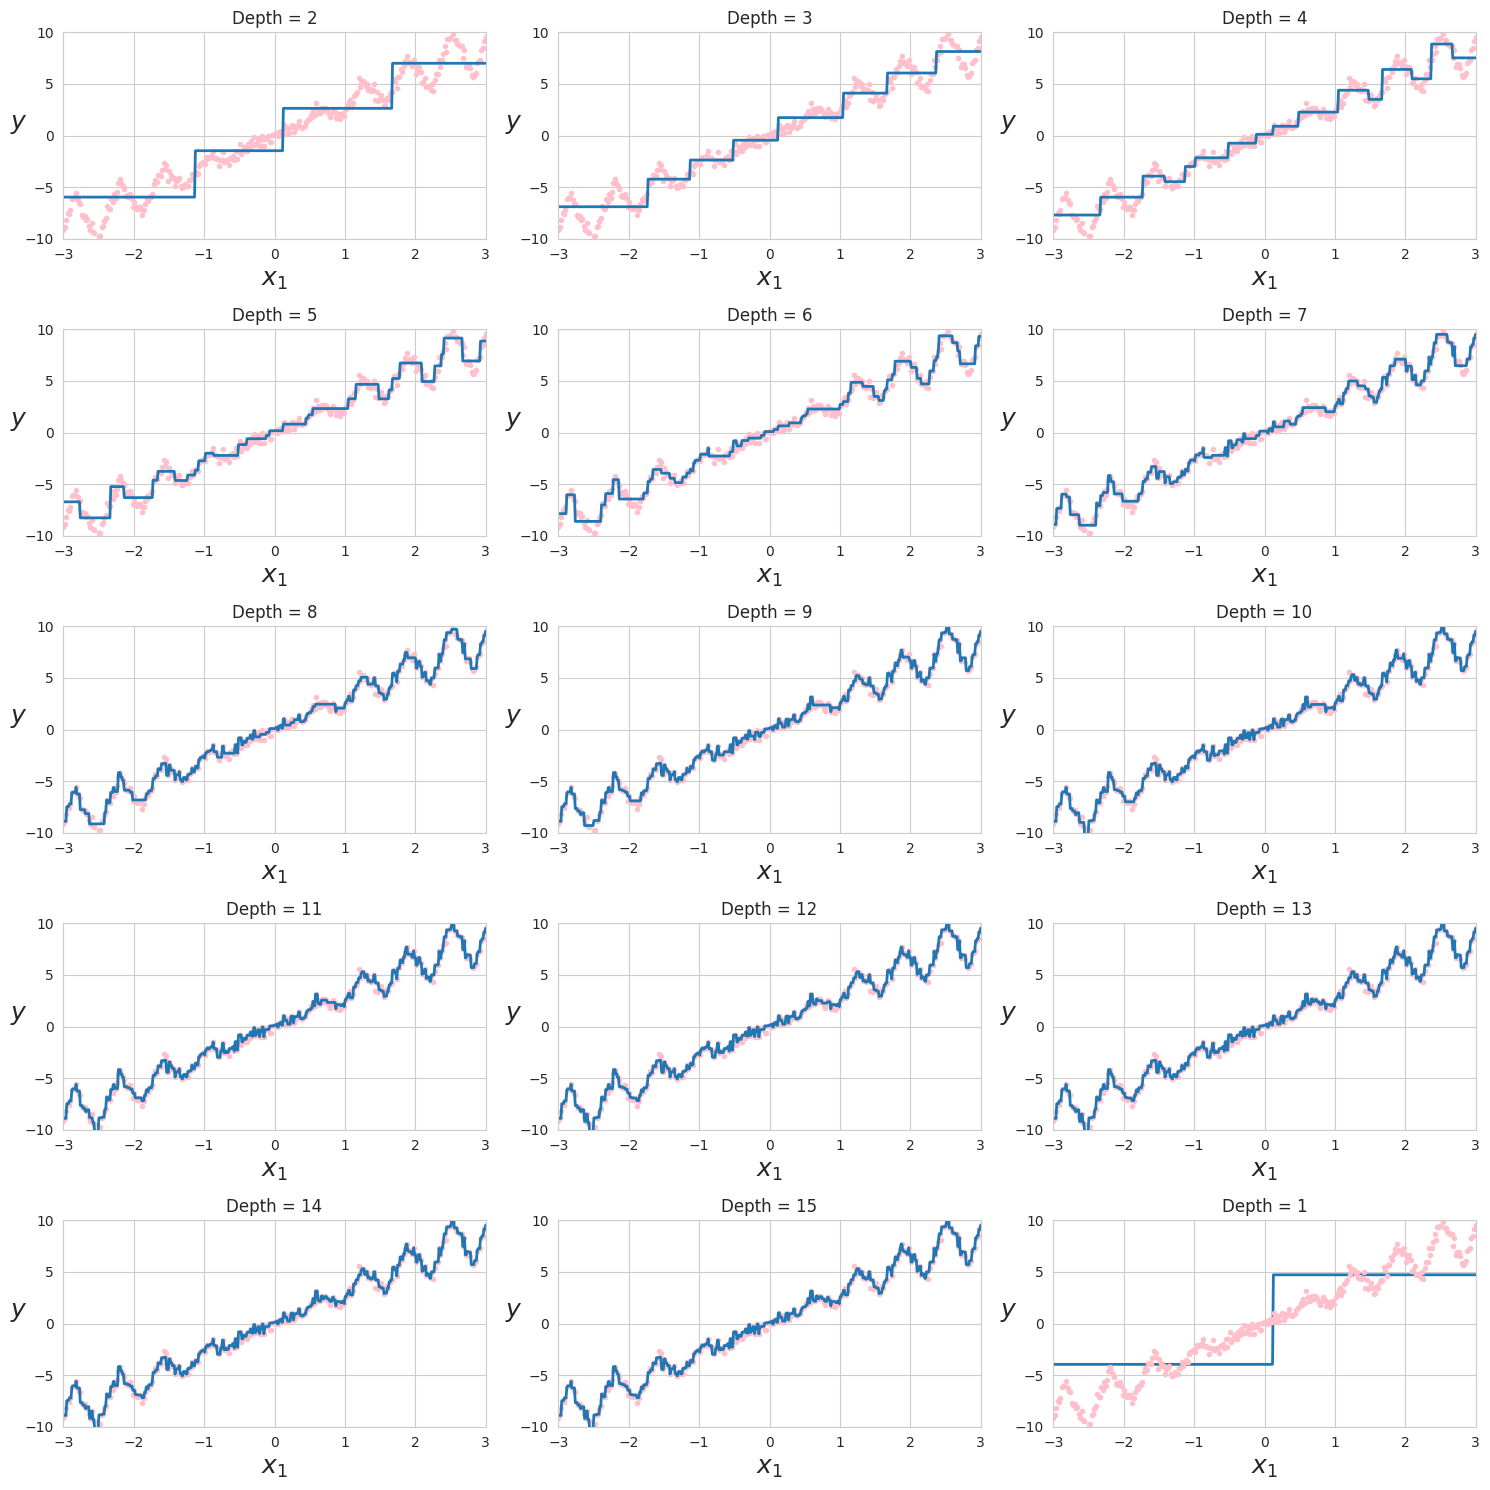

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
depth = []
fig, axs = plt.subplots(5, 3, figsize=(15, 15))  

for i in range(1, 16):

    clf = DecisionTreeRegressor(max_depth=i, random_state=SEED)
    clf.fit(X_train, y_train)
   
    plot_regression_predictions(clf, X_test, y_test, axes=[-3, 3, -10, 10], ylabel="$y$")
    plt.subplot(5, 3, i)
    
    plt.plot(X.reshape(-1), y.reshape(-1), "b.", color = 'pink')
    plt.title(f'Depth = {i%15+1}')  

plt.tight_layout()
plt.show()

# я так и не поняла почему сабплоты расположились так, я удивилась, поразилась, негодовала,  но потом нашла как все правильно собрать и подписать.



   

    


При глубине больше 8 модели стремятс предсказать каждую точку и становятся переобученными, мне кажется все модели при глубине более 4 неплохо отражают тренд, оптимальной глубиной кажется 6, ну или 7

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

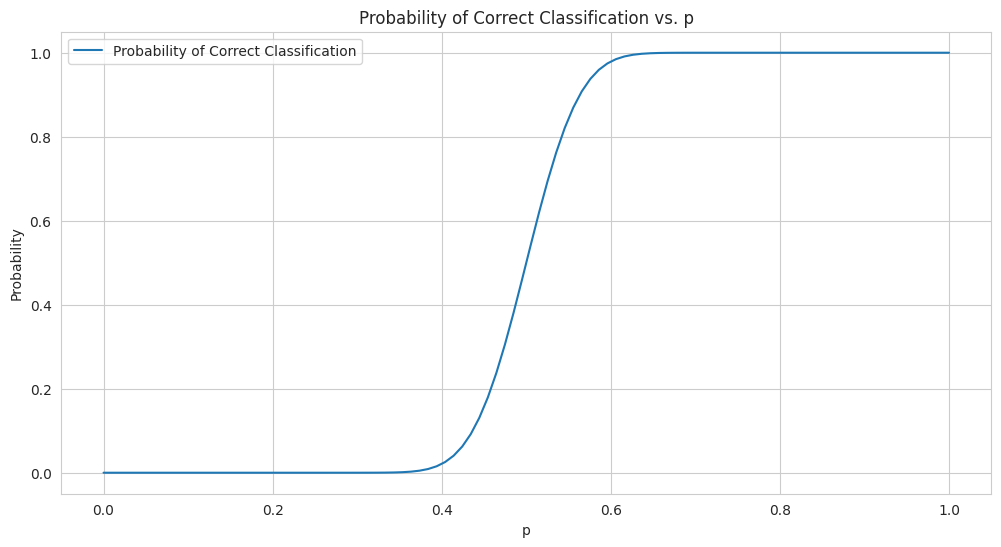

In [7]:

p_values = np.linspace(0, 1, 100)
p_correct = []
for p in p_values:
    prob_correct = sum([(math.factorial(101)/(math.factorial(k)*math.factorial(101-k))) * p**k * (1-p)**(101-k) for k in range(51, 102)])
    p_correct.append(prob_correct)
plt.figure(figsize=(12, 6))
plt.plot(p_values, p_correct, label='Probability of Correct Classification')
plt.xlabel('p')
plt.ylabel('Probability')
plt.title('Probability of Correct Classification vs. p')
plt.legend()
plt.grid(True)
plt.show()


А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

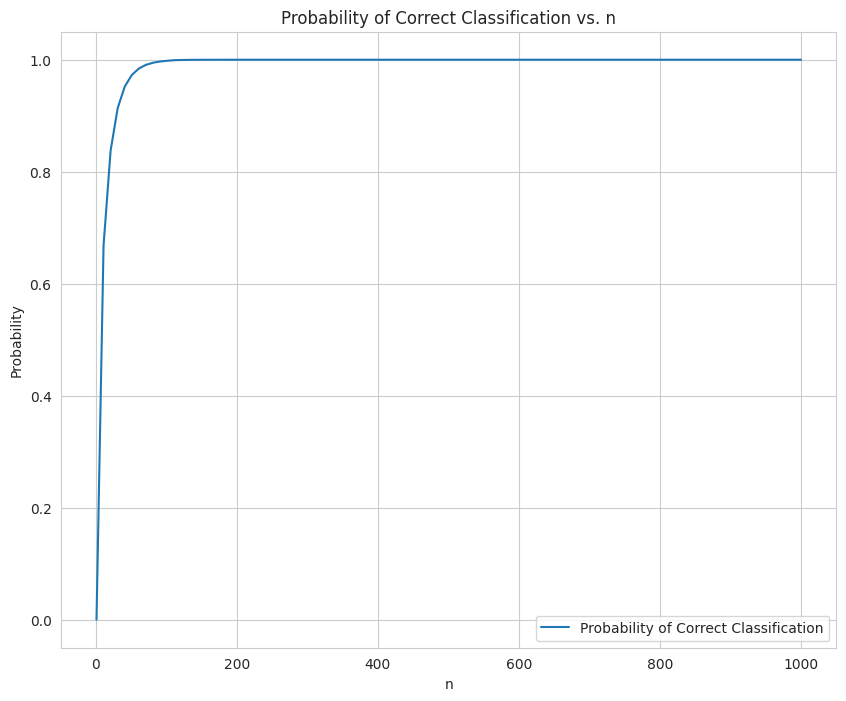

In [8]:

p = 0.65

n_values =(np.linspace(1, 1000, 100))
n_values = n_values.astype(int)
p_correct = []

for n in n_values:
    prob_correct = 0
    for k in range(n//2+1 + n%2, n+1):
        prob_correct += math.comb(n, k) * (p**k) * ((1-p)**(n-k))
    p_correct.append(prob_correct)
#print(p_correct)
plt.figure(figsize=(10, 8))
plt.plot(n_values, p_correct, label='Probability of Correct Classification')
plt.xlabel('n')
plt.ylabel('Probability')
plt.title('Probability of Correct Classification vs. n')
plt.legend()
plt.grid(True)
plt.show()

Опишите ваши наблюдения:

* При вероятности 0.5 даже при 101 классификаторе итоговая вероятность будет 0.5, но .в целом логично, при этом дальше зависимость быстро сходится к 1, то есть даже если возникает небольшой перевес в сторону правильного определния, то при большом количестве классификаторов, модель все быстрее пиходит к правильной работе
* При увеличение числа классификаторов ероятность правильного определения нарастает экспоненциально и сходится к 1

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [9]:
class RandomForestClassifierCustom(BaseEstimator):

    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.random_state_initial = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        for i in range (0, self.n_estimators - 1):
            self.random_state = np.random.seed(self.random_state_initial + i)
            indices_features = np.random.choice(range(X.shape[1]), size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(indices_features)
            pseudo_X_indices = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
            pseudo_X = X[pseudo_X_indices]
            pseudo_y = y[pseudo_X_indices]
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(pseudo_X[:, indices_features], pseudo_y)
            self.trees.append(tree)
        return self


    def predict_proba(self, X):
            predictions = np.zeros((X.shape[0], len(self.classes_)))  # Создаем массив для предсказаний вероятностей для каждого класса

            for i in range(0, self.n_estimators-1):
                tree = self.trees[i]
                feat_ids = self.feat_ids_by_tree[i]
                prediction = tree.predict(X[:, feat_ids])

                for j in range(X.shape[0]):
                    pred_class = prediction[j]
                    predictions[j, pred_class] += 1  # Увеличиваем счетчик для предсказанного класса

            return predictions / self.n_estimators
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [10]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

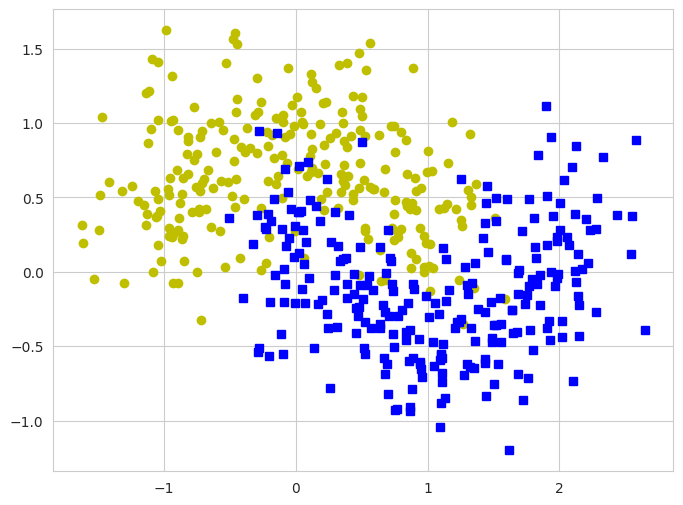

In [11]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()


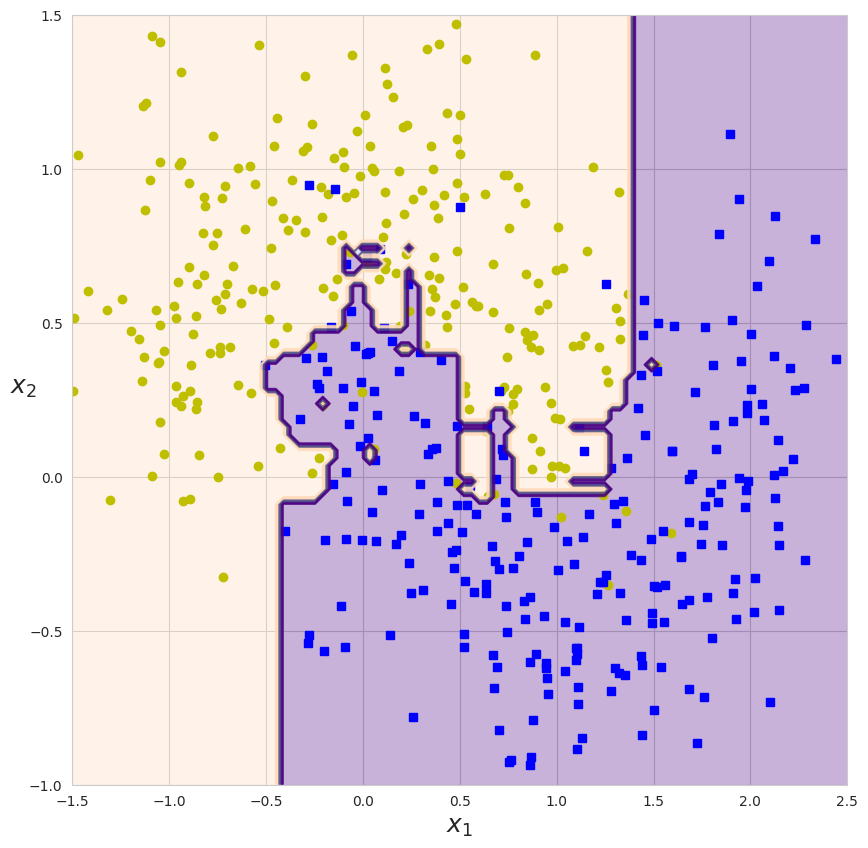

In [12]:
plt.figure(figsize=(10, 10))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
clf = RandomForestClassifierCustom(n_estimators=10, max_depth=20, max_features=2, random_state=SEED)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y, alpha=0.02, contour=True)

plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

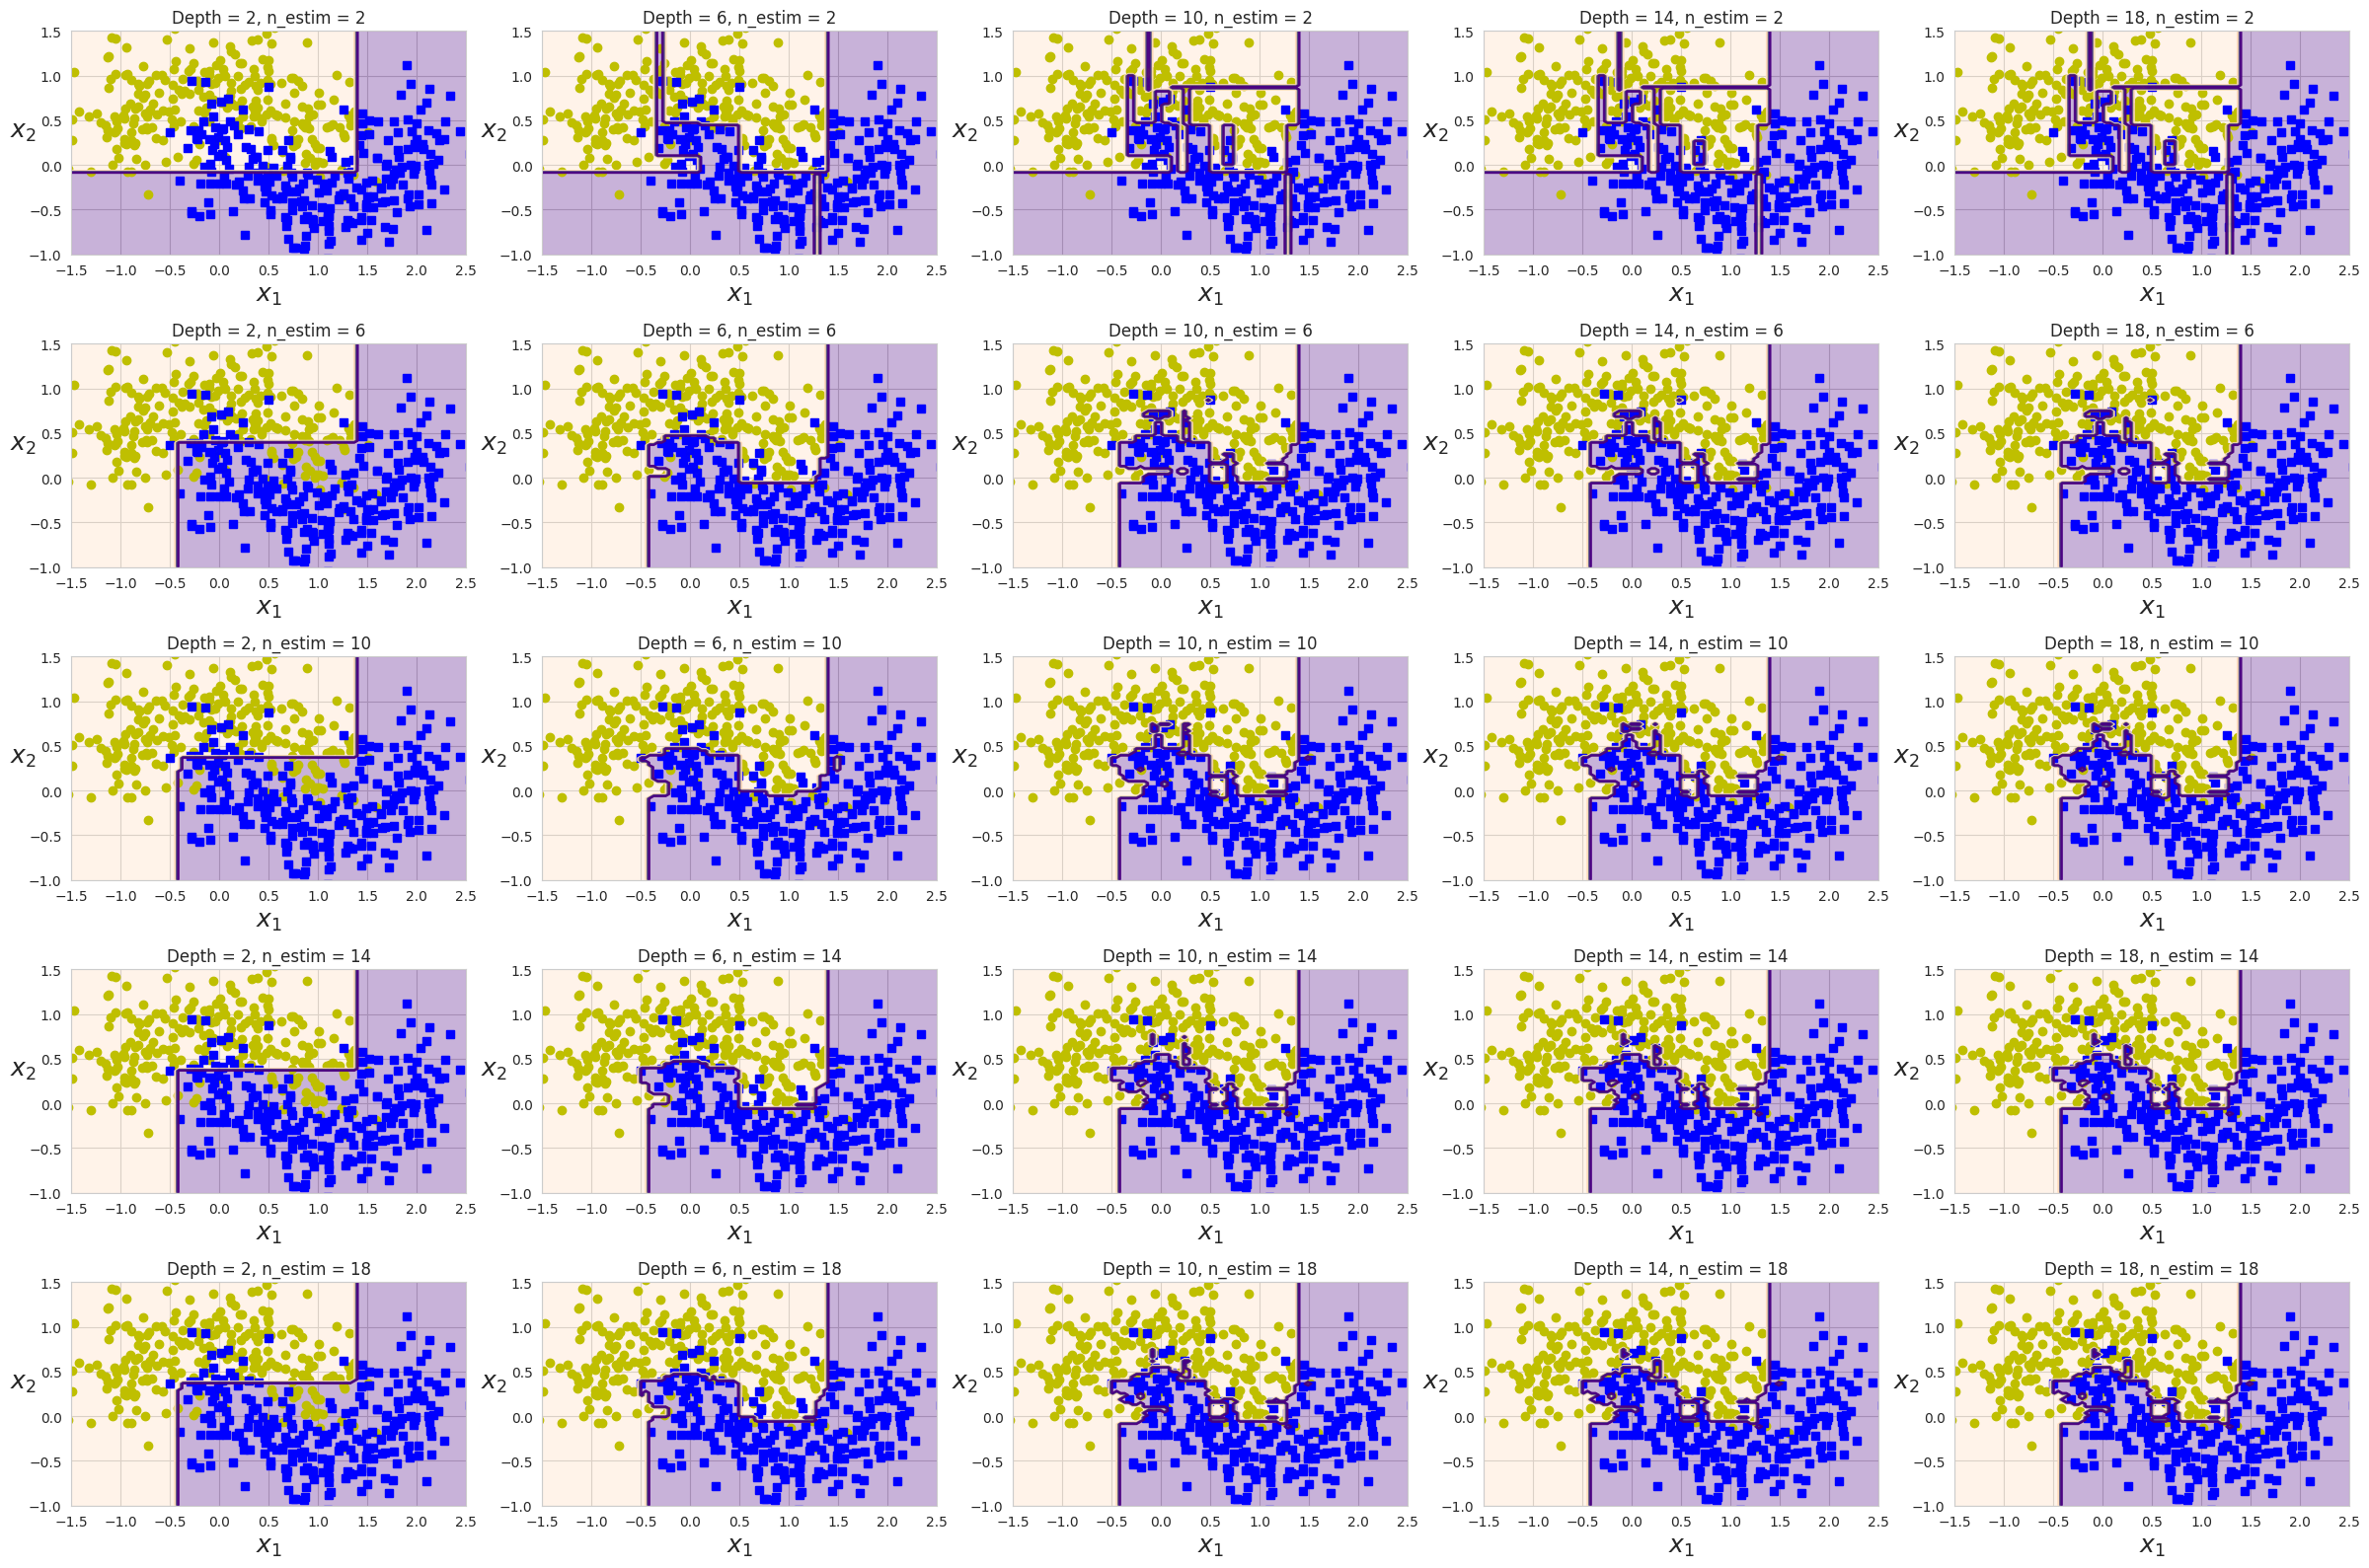

In [13]:
k = 1
plt.figure(figsize=(24, 16))
for i in range(2, 22, 4):
    for j in range(2, 20, 4):
        plt.subplot(5, 5, k)
        #plt.figure(figsize=(10, 10))
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
        clf = RandomForestClassifierCustom(n_estimators=(i), max_depth=(j), max_features=2, random_state=SEED)
        clf.fit(X_train, y_train)
        plot_decision_boundary(clf, X, y, alpha=0.02, contour=True)
        
        plt.title(f'Depth = {j}, n_estim = {i}')
        k +=1  
       

plt.tight_layout()
plt.show()

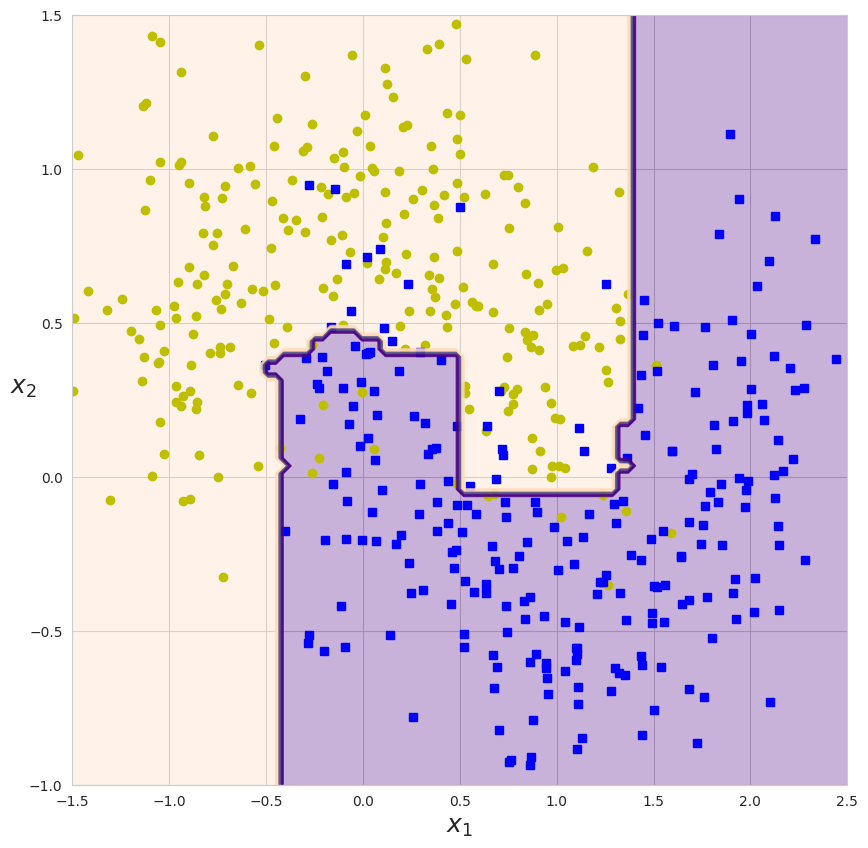

In [14]:
plt.figure(figsize=(10, 10))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
clf = RandomForestClassifierCustom(n_estimators=10, max_depth=5, max_features=2, random_state=SEED)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y, alpha=0.02, contour=True)

plt.show()

Я сделала, это вручную, при глубине дерева больше 6 начинают появляться отдельные кластеры для индивидуальных точек, которые не попадают в основной пул,  модель становится переобученной, это не кажется разумным.  При увеличении количества деревьев лесу > 10 не приводит к особому изменению модели.
Я бы остановилась на глубине 5 и количестве деревьев - 10

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [15]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [16]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)


прочитала, что в этом датасете 30 признаков и 569 образцов, бинарная классификация

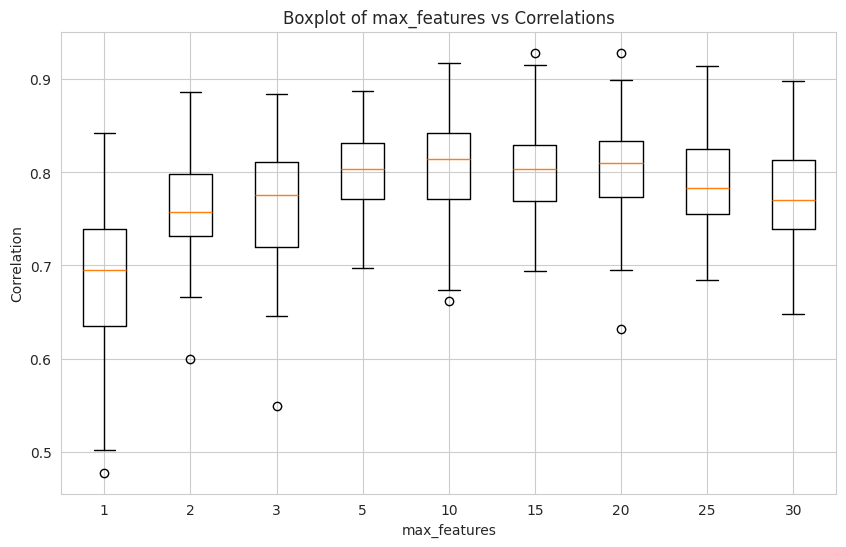

In [17]:
correlations = []
max_features = [1, 2, 3, 5, 10, 15, 20, 25, 30]
for mf in max_features:
    rf_clf = RandomForestClassifier(n_estimators = 15, max_features=mf, random_state= SEED)
    rf_clf.fit(X_train, y_train)
    correlations.append(base_model_pair_correlation(rf_clf, X_test))
correlations  
plt.figure(figsize=(10, 6))
plt.boxplot(correlations, labels = max_features)
plt.xlabel('max_features')
plt.ylabel('Correlation')
plt.title('Boxplot of max_features vs Correlations')
plt.grid(True)
plt.show()  

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

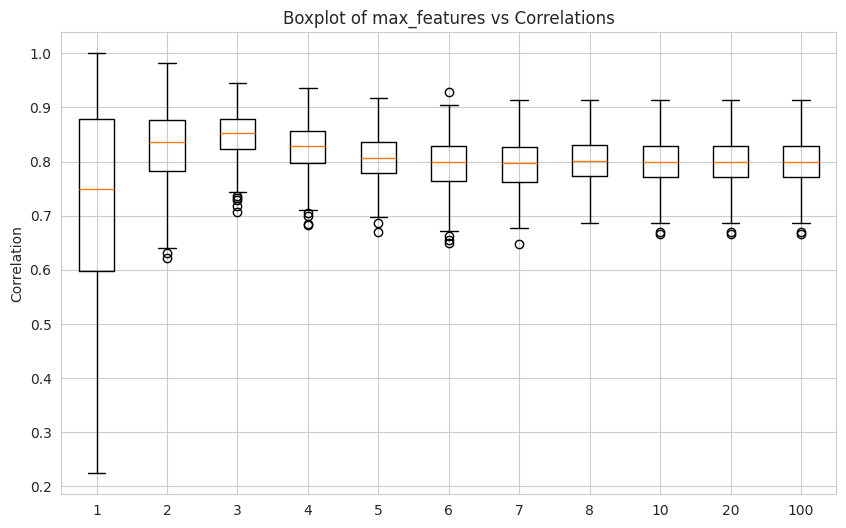

In [18]:
correlations = []
max_d = [1, 2, 3, 4, 5, 6, 7,  8, 10, 20,  100]
for md in max_d:
    rf_clf = RandomForestClassifier(n_estimators = 30, max_depth=md, random_state= SEED)
    rf_clf.fit(X_train, y_train)
    correlations.append(base_model_pair_correlation(rf_clf, X_test))
plt.figure(figsize=(10, 6))
plt.boxplot(correlations, labels = max_d)
#plt.xlabel('max_features')
plt.ylabel('Correlation')
plt.title('Boxplot of max_features vs Correlations')
plt.grid(True)
plt.show()      

Опишите ваши наблюдения:

* При увеличении количества features, корреляция растет, а потом немного падает
* max_depth, видим, что с какого-то момента показатели не мзменяются, то есть построение дерева останавливается до достижения максимальной глубины, при ее увеличении показатель корреляции растет, так как больше возможностей задать вопрос - стремимся к чему-то похожему, а потом чуть падает до стабильного уровня

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [19]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [20]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [21]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [22]:

voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')


## END YOUR CODE HERE ##
results = []

for model in [voting_soft, dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    results.append(f"{model.__class__.__name__}: {scores.mean()}")
    print(f"{model.__class__.__name__}: {scores.mean()}")

[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [23]:
#посмотрим без warning'оф
for r in results:
    print(r)

VotingClassifier: 0.8455110375195781
DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
LGBMClassifier: 0.817010631644778
XGBRFClassifier: 0.8499478840942256
LGBMClassifier: 0.8132478632478634
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8494440278941667


Максимальное значение 0.8494
Надо пробовать убирать коррелирующие модели

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [24]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

Построим таблицу с корреляциями для двух моделей между собой и отсортируем значения по возрастанию

In [25]:
voting_soft_cls = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft_cls.fit(X_train, y_train)
solf_voting_corr = base_model_pair_correlation_for_voting_clf(voting_soft_cls, X)
solf_voting_corr = pd.DataFrame(solf_voting_corr, columns=['Model A', 'Model B', 'Corr'])


[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [26]:
display(solf_voting_corr)
display(solf_voting_corr.sort_values('Corr', ascending=False).head(15))


,Model A,Model B,Corr
0,"DecisionTreeClassifier(max_depth=10, min_sampl...","(DecisionTreeClassifier(max_features='sqrt', r...",0.859324
1,"DecisionTreeClassifier(max_depth=10, min_sampl...","(ExtraTreeClassifier(random_state=481767252), ...",0.793948
2,"DecisionTreeClassifier(max_depth=10, min_sampl...",KNeighborsClassifier(weights='distance'),0.735671
3,"DecisionTreeClassifier(max_depth=10, min_sampl...","SVC(kernel='linear', probability=True, random_...",0.812515
4,"DecisionTreeClassifier(max_depth=10, min_sampl...","SVC(probability=True, random_state=111)",0.504944
...,...,...,...
73,"XGBClassifier(base_score=None, booster=None, c...","LogisticRegression(max_iter=10000, solver='lib...",0.792146
74,"XGBClassifier(base_score=None, booster=None, c...",GaussianNB(),0.733600
75,"XGBRFClassifier(base_score=None, booster=None,...","LogisticRegression(max_iter=10000, solver='lib...",0.882941
76,"XGBRFClassifier(base_score=None, booster=None,...",GaussianNB(),0.814237


,Model A,Model B,Corr
64,LGBMClassifier(random_state=111),"XGBClassifier(base_score=None, booster=None, c...",0.990632
57,<catboost.core.CatBoostClassifier object at 0x...,LGBMClassifier(random_state=111),0.987400
16,"(DecisionTreeClassifier(max_features='sqrt', r...",<catboost.core.CatBoostClassifier object at 0x...,0.983311
59,<catboost.core.CatBoostClassifier object at 0x...,"XGBClassifier(base_score=None, booster=None, c...",0.978323
17,"(DecisionTreeClassifier(max_features='sqrt', r...",LGBMClassifier(random_state=111),0.974589
29,"(ExtraTreeClassifier(random_state=481767252), ...","XGBClassifier(base_score=None, booster=None, c...",0.970791
12,"(DecisionTreeClassifier(max_features='sqrt', r...","(ExtraTreeClassifier(random_state=481767252), ...",0.968670
26,"(ExtraTreeClassifier(random_state=481767252), ...",<catboost.core.CatBoostClassifier object at 0x...,0.968586
19,"(DecisionTreeClassifier(max_features='sqrt', r...","XGBClassifier(base_score=None, booster=None, c...",0.968047
27,"(ExtraTreeClassifier(random_state=481767252), ...",LGBMClassifier(random_state=111),0.963169


Видим, что часто коррелирует со всеми XGBClassifier, LGBMClassifier, попробую их убрать

In [27]:


good_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM_RF", lgbm_rf), 
                ("LR", lr), ("NB", nb)]

results = []
voting_hard = VotingClassifier(estimators=good_models, voting='hard')
voting_soft = VotingClassifier(estimators=good_models, voting = 'soft')

for model in [voting_soft, voting_hard]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    results.append(f"{model.__class__.__name__}: {scores.mean()}")
    print(f"{model.__class__.__name__}: {scores.mean()}")
for r in results:
    print(r)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[Li

Из лучшего:
```good_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM_RF", lgbm_rf), 
                ("LR", lr), ("NB", nb)]
С этим набором было 0.8555    

good_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), 
               ("CAT", cat), 
               ("LGBM_RF", lgbm_rf), 
                ("LR", lr), ("NB", nb)]
с этим 0.857                

good_models = [("DT", dt), ("RF", rf), 
               ("SVC_LIN", svc_lin), 
               ("LGBM_RF", lgbm_rf)]
               c этим 0.859```

Еще я делала переборы по 2 и 3 классификатора и не добивалась успеха, билась вокруг 0.858, 0.859               

In [28]:
good_models = [("DT", dt), ("RF", rf), 
               ("SVC_LIN", svc_lin), 
               ("LGBM_RF", lgbm_rf)]

results = []
voting_hard = VotingClassifier(estimators=good_models, voting='hard')
voting_soft = VotingClassifier(estimators=good_models, voting = 'soft')

for model in [voting_soft, voting_hard]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    results.append(f"{model.__class__.__name__}: {round(scores.mean(), 2)}")
    #print(f"{model.__class__.__name__}: {scores.mean()}")
for r in results:
    print(r)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[Li

Чтобы просто увидеть  0.86 я сделаю вот так, это стоило мне слишком много времени, и сил на решение дз дальше что-то не хватило

In [29]:
good_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), 
               ("CAT", cat), 
               ("LGBM_RF", lgbm_rf), 
                ("LR", lr), ("NB", nb)]
results = []
voting_hard = VotingClassifier(estimators=good_models, voting='hard')
voting_soft = VotingClassifier(estimators=good_models, voting = 'soft')

for model in [voting_soft, voting_hard]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    results.append(f"{model.__class__.__name__}: {round(scores.mean(), 2)}")
    #print(f"{model.__class__.__name__}: {scores.mean()}")
for r in results:
    print(r)                

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[Li

In [30]:
good_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM_RF", lgbm_rf), 
                ("LR", lr), ("NB", nb)]


voting_hard = VotingClassifier(estimators=good_models, voting='hard')
voting_soft = VotingClassifier(estimators=good_models, voting = 'soft')

for model in [voting_soft, voting_hard]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    results.append(f"{model.__class__.__name__}: {scores.mean()}")
    print(f"{model.__class__.__name__}: {scores.mean()}")
for r in results:
    print(r)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[Li

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [31]:
#data = pd.read_csv("churn.csv")
#data.head()

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [32]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

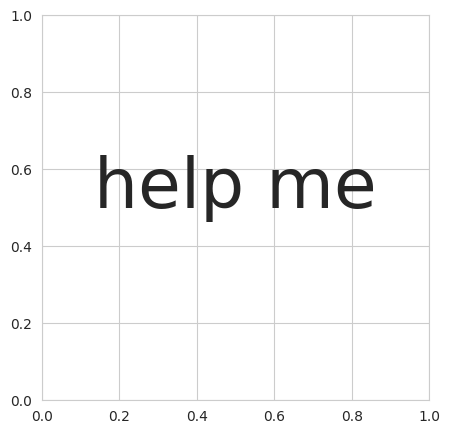

In [33]:
plt.figure(figsize=(5, 5))

plt.text(0.5, 0.5, 'help me', size=50, ha='center')
plt.show()

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Очень, интересно, но подбор комбинаций для классификаторов ранил, ранил и убил